In [62]:
import json
import os
import time
from VIPurPCAvsMC import *
from utils import *
import jax.numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA as pca_sklearn

In [75]:
def cvp(jvp_fun, vjp_fun, X_flat, X_unflattener, C_flat, n, p, p_keep, i):
    v1 = np.ravel(jax.nn.one_hot(np.array([i]), min(n, p_keep)*p))
    v2 = vjp_fun(v1)[0]
    v3 = np.multiply(v2, C_flat)
    v4 = jvp_fun(v3)
    return v4

In [73]:
d = pd.read_csv('../data/CNS/mean.csv', sep=';', header=0)
X = np.transpose(d.values)
X = X - np.mean(X, axis=0)
print(np.percentile(np.var(X, axis=0), 99))
print(np.var(X, axis=0).shape)
selector = VarianceThreshold(threshold=np.percentile(np.var(X, axis=0), 90))
X = selector.fit_transform(X)
print(X.shape)
X_flat, X_unflattener = flatten_util.ravel_pytree(X)
#A = np.load('../data/macrophage/A.npy')
#B = np.load('../data/macrophage/B.npy')
#A = A + 1e-3*np.eye(A.shape[0])
#B = B + 1e-3*np.eye(B.shape[0])
C = pd.read_csv('../data/CNS/var.csv', sep=';', header=None)
C = np.transpose(C.values)
C = selector.transform(C)
C = np.maximum(C, 1e-6)
C_flat, C_unflattener = flatten_util.ravel_pytree(C)
print(C.shape)

6.370095
(7127,)
(42, 713)
(42, 713)


In [76]:
p_keep=4
n, p = X.shape
start = time.time()
print('Start PCA')
V = pca(X_flat, X_unflattener, p_keep)
#V = np.reshape(V, (p_keep, p), 'C')
#T = np.dot(X, np.transpose(V))
# VIPurPCA
f = lambda X: pca(X, X_unflattener, p_keep)
_, f_vjp = vjp(f, X_flat)
_, f_jvp = jax.linearize(f, X_flat)
cvp_fun = lambda s: cvp(f_jvp, f_vjp, X_flat, X_unflattener, C_flat, n, p, p_keep, s)
#C = np.array([cvp_fun(i) for i in range(min(n, p_keep)*p)])
#C = map(cvp_fun, np.arange(min(n, p_keep)*p))
#C = map(cvp_fun, np.arange(1))
batch_size = 1000
b = batch(np.arange(min(n, p_keep)*p), batch_size)
C_output = np.vstack([vmap(cvp_fun)(i) for i in b])
#C = vmap(cvp_fun)(np.arange(min(n, p_keep)*p))
end = time.time()
print(end-start)
# Monte-Carlo
#n_iter = 1000
#Vs = MC(X_flat, X_unflattener, A, B, p_keep, n_iter, batch_size)
#Vs = vmap(outer_function_correcting, (0, None), 0)(Vs, np.reshape(V, (min(n, p_keep), p), 'C'))
#T_mcs = np.array([X @ np.transpose(i) for i in Vs])
#Vs = vmap(lambda x: np.ravel(x, 'C'))(Vs)
#C_mc = np.cov(np.transpose(Vs))

Start PCA
5.520387887954712


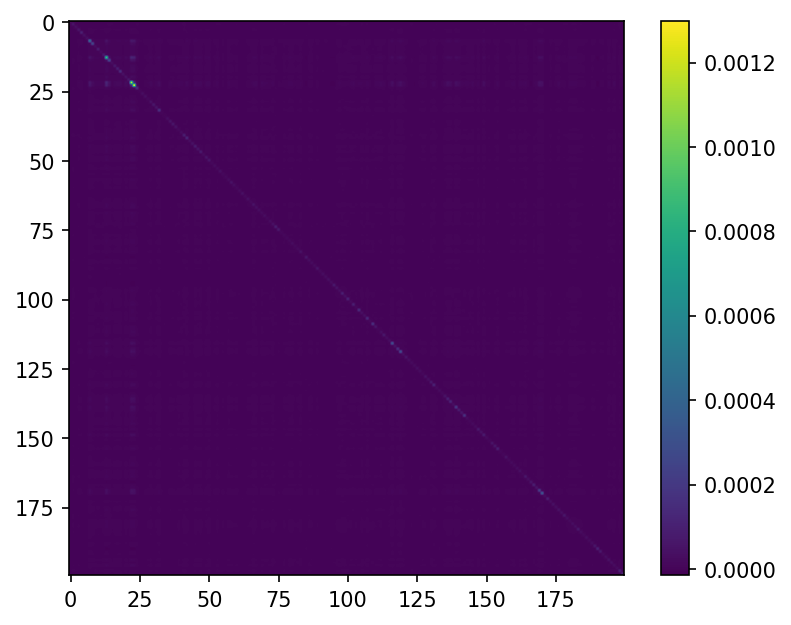

In [77]:
plt.imshow(C_output[0:200, 0:200])
plt.colorbar()

In [35]:
le = LabelEncoder()
labels = le.fit_transform(list(d.columns.values))
labels = list(d.columns.values)
print(labels)
labels = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4]
m = ["o", "v", "x", "+", "1"]

['brain_MD_12', 'brain_MD_61', 'brain_MD_15', 'brain_MD_57', 'brain_MD_33', 'brain_MD_64', 'brain_MD_17', 'brain_MD_62', 'brain_MD_63', 'brain_MD_32', 'brain_MGlio_1', 'brain_MGlio_2', 'brain_MGlio_3', 'brain_MGlio_4', 'brain_MGlio_5', 'brain_MGlio_6', 'brain_MGlio_7', 'brain_MGlio_8', 'brain_MGlio_9', 'brain_MGlio_10', 'brain_Rhab_1', 'brain_Rhab_2', 'brain_Rhab_3', 'brain_Rhab_4', 'brain_Rhab_5', 'brain_Rhab_6', 'brain_Rhab_7', 'brain_Rhab_8', 'brain_Rhab_9', 'brain_Rhab_10', 'brain_Ncer_1', 'brain_Ncer_2', 'brain_Ncer_3', 'brain_Ncer_4', 'brain_PNET_1', 'brain_PNET_2', 'brain_PNET_3', 'brain_PNET_4', 'brain_PNET_5', 'brain_PNET_6', 'brain_PNET_7', 'brain_PNET_8']


In [51]:
n_iter = 100
key = jax.random.PRNGKey(42)
V_drawn = jax.random.multivariate_normal(key, V, C_output+1e-4*np.eye(V.shape[0]), shape=(n_iter,))
T_s = np.array([X @ np.transpose(np.reshape(i, (p_keep, p), 'C')) for i in V_drawn])

In [49]:
V_draw.shape

(100, 28508)

In [19]:
np.sum(V_drawn)

DeviceArray(10184.465, dtype=float32)

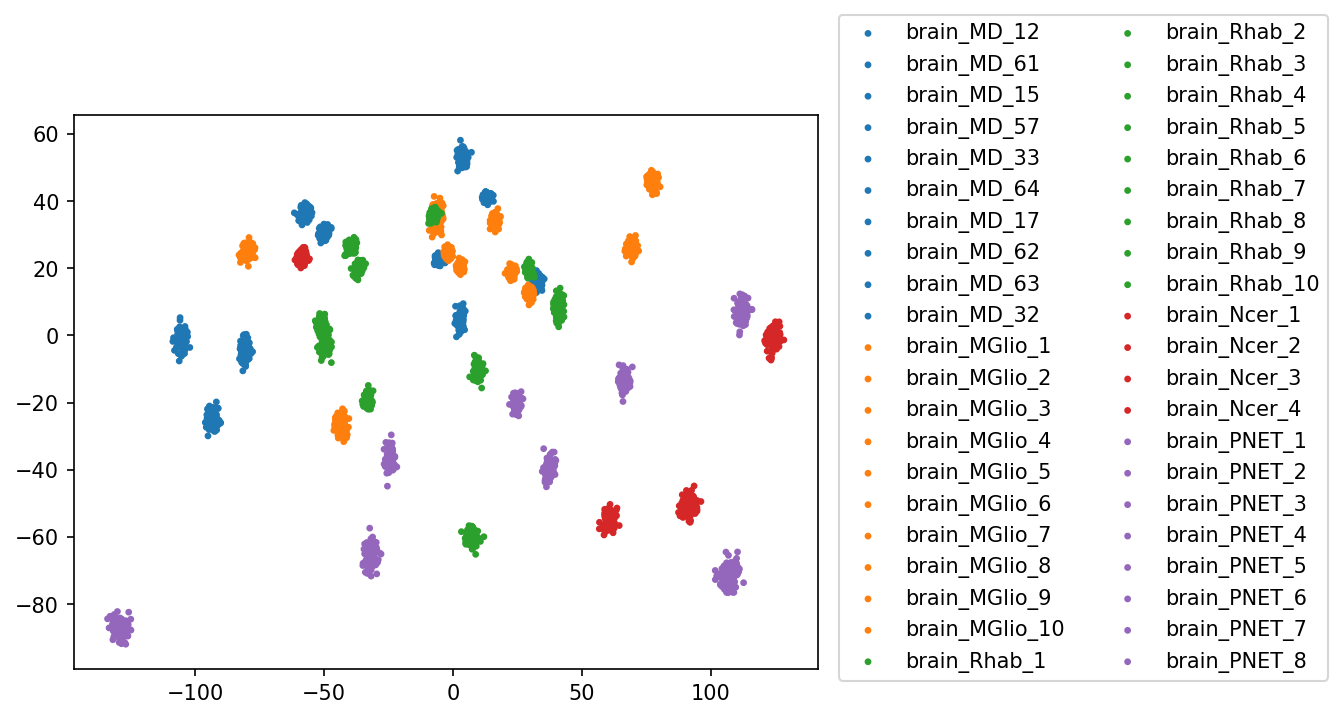

In [80]:
f, ax1 = plt.subplots(1)
pcx, pcy = (0, 1)
for j in range(n):
    ax1.scatter(x=T_s[:, j, pcx], y=T_s[:, j, pcy], s=5, label=list(d.columns.values)[j], c=['C'+str(labels[j]) for i in range(n_iter)])#, marker=m[labels2[j]], alpha=.5)
    #ax2.scatter(x=T_mcs[:, j, pcx], y=T_mcs[:, j, pcy], s=5)
ax1.legend(loc='upper right', bbox_to_anchor=(1.7, 1.2), ncol=2)